In [1]:
#Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Dataset Load
url = '../input/prediction-of-purchased-car/Social_Network_Ads.csv'
data = pd.read_csv(url, header='infer')

**Exploration**

In [3]:
data.shape

(400, 5)

In [4]:
#checking for null or missing values
data.isna().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

**Pre-Processing**

In [5]:
#dropping the User Id column
data = data.drop(columns='User ID',axis=1)

In [6]:
#Function to define category name for Purchased column

def pur_cat(pur_code):
    if pur_code == 0:
        return 'Not Purchased'
    else:
        return 'Purchased'
    
#Applying the function to Purchased Column
data['Purchased'] = data['Purchased'].apply(pur_cat)


In [7]:
data.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,Not Purchased
1,Male,35,20000,Not Purchased
2,Female,26,43000,Not Purchased
3,Female,27,57000,Not Purchased
4,Male,19,76000,Not Purchased


> **Data Visualisation**

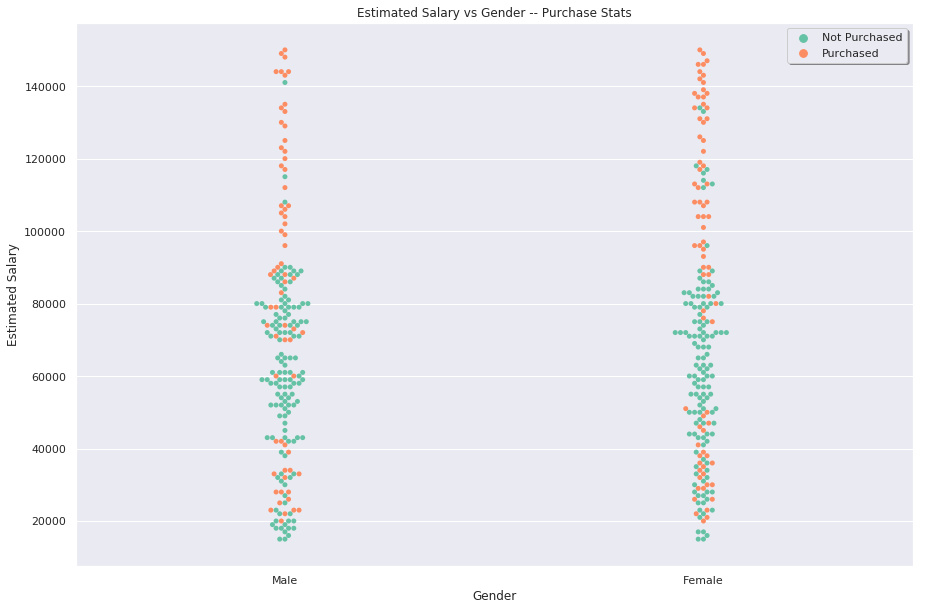

In [8]:
#Estimated Salary vs Gender -- Purchase Stats
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.swarmplot (x='Gender', y='EstimatedSalary', data=data, hue = 'Purchased',palette="Set2")
plt.title('Estimated Salary vs Gender -- Purchase Stats')
plt.ylabel('Estimated Salary')
plt.xlabel('Gender')
ax.legend(fancybox=True, shadow=True )

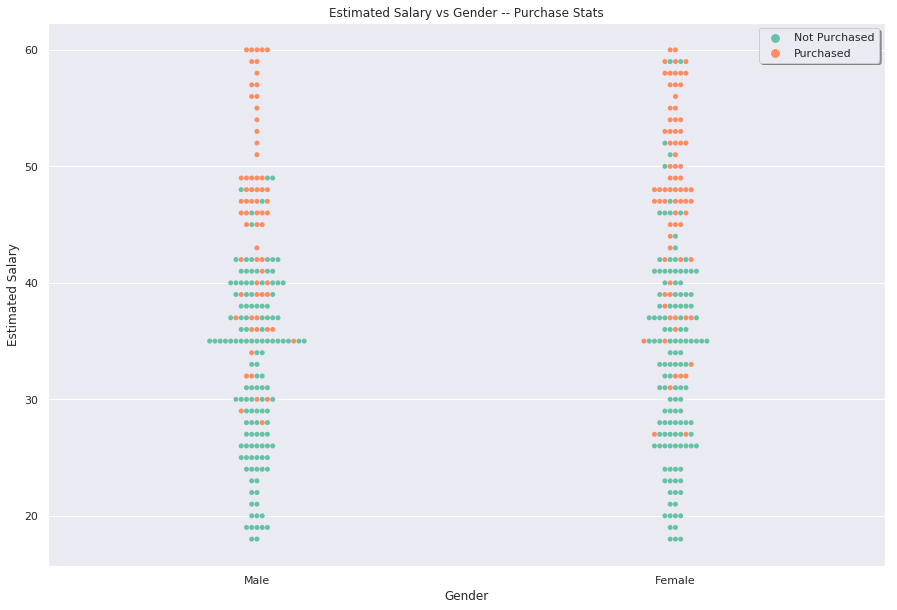

In [9]:
#Estimated Age vs Gender -- Purchase Stats
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.swarmplot (x='Gender', y='Age', data=data, hue = 'Purchased',palette="Set2")
plt.title('Estimated Salary vs Gender -- Purchase Stats')
plt.ylabel('Estimated Salary')
plt.xlabel('Gender')
ax.legend(fancybox=True, shadow=True )

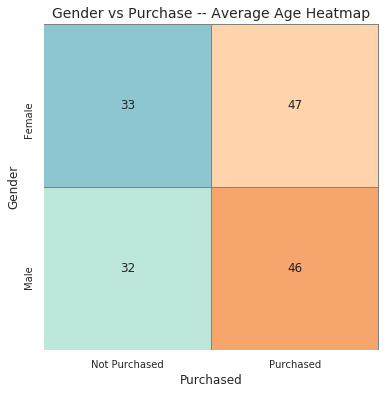

In [10]:
#Gender vs Purchase -- Average Age Heatmap
AvgAge_PTable = data.pivot_table(values='Age', index='Gender', columns='Purchased', aggfunc=np.mean)

# Using seaborn heatmap
plt.figure(figsize=(6,6))
plt.title('Gender vs Purchase -- Average Age Heatmap', fontsize=14)
plt.tick_params(labelsize=10)
sns.heatmap(AvgAge_PTable.round(), cmap='icefire', linecolor='grey',linewidths=0.1, cbar=False, annot=True, fmt=".0f")

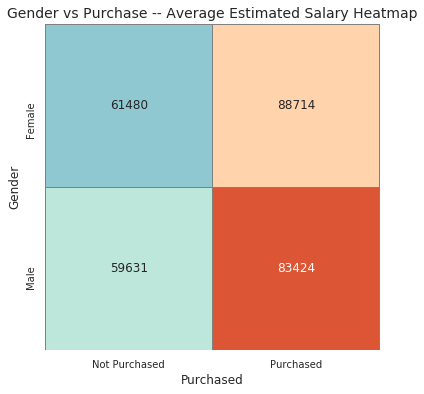

In [11]:
#Gender vs Purchase -- Average Estimated Salary Heatmap
AvgSal_PTable = data.pivot_table(values='EstimatedSalary', index='Gender', columns='Purchased', aggfunc=np.mean)

# Using seaborn heatmap
plt.figure(figsize=(6,6))
plt.title('Gender vs Purchase -- Average Estimated Salary Heatmap', fontsize=14)
plt.tick_params(labelsize=10)
sns.heatmap(AvgSal_PTable.round(), cmap='icefire', linecolor='grey',linewidths=0.1, cbar=False, annot=True, fmt=".0f")

**Modeling & Prediction**

Under modeling & prediction, I shall compare multiple Classifier Models from SKLEARN library and try to find the model with highest accuracy. The model that gives the higest accuracy will then be used for making predictions on unseen data

In [12]:
# --- Importing ML libraries ---
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder 

#Metrics Libraries
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#ML Classifier Algorithm Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

**Converting the Gender category to numerical code using Label Encoding**

In [13]:
lae = LabelEncoder()

data['Gender'] = lae.fit_transform(data['Gender'])

In [14]:
#Backup of the original dataset
data_backup = data.copy()

Since there is no seperate test dataset, I will slice the top 10 rows of the existing dataset and use them as "unseen" dataset for validating the model at the end.

In [15]:
#creating unseen dataframe
unseen_df = data.iloc[:10,:]

In [16]:
unseen_df.head(10)

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,Not Purchased
1,1,35,20000,Not Purchased
2,0,26,43000,Not Purchased
3,0,27,57000,Not Purchased
4,1,19,76000,Not Purchased
5,1,27,58000,Not Purchased
6,0,27,84000,Not Purchased
7,0,32,150000,Purchased
8,1,25,33000,Not Purchased
9,0,35,65000,Not Purchased


In [17]:
#Dropping the top 10 rows from the original dataset
data.drop(data.index[:10],inplace=True)

# Re-indexing the original dataset
data.reset_index(inplace=True, col_level=1, drop=True)

In [18]:
data.head(10)

,Gender,Age,EstimatedSalary,Purchased
0,0,26,80000,Not Purchased
1,0,26,52000,Not Purchased
2,1,20,86000,Not Purchased
3,1,32,18000,Not Purchased
4,1,18,82000,Not Purchased
5,1,29,80000,Not Purchased
6,1,47,25000,Purchased
7,1,45,26000,Purchased
8,1,46,28000,Purchased
9,0,48,29000,Purchased


In [19]:
#Feature & Target Selection
features = ['Gender', 'Age', 'EstimatedSalary']
target = ['Purchased']

# Feature& Target  Dataset
X = data[features]
y = data[target]

In [20]:
#Dataset Split  [train = 90%, test = 10%]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) 

#Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Model Creation & Evaluation**

In [21]:
# -- Building Model List --
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RFC', RandomForestClassifier()))

In [22]:
# -- Model Evaluation --
model_results = []
model_names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=None, shuffle=False)
    cross_val_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    model_results.append(cross_val_results)
    model_names.append(name)
    print(name, ":--", "Mean Accuracy =", '{:.2%}'.format(cross_val_results.mean()), 
                       "Standard Deviation Accuracy =", '{:.2%}'.format(cross_val_results.std())
         )

CART :-- Mean Accuracy = 86.33% Standard Deviation Accuracy = 5.51%
KNN :-- Mean Accuracy = 90.32% Standard Deviation Accuracy = 6.01%
LDA :-- Mean Accuracy = 82.93% Standard Deviation Accuracy = 6.91%
NB :-- Mean Accuracy = 88.06% Standard Deviation Accuracy = 5.15%


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

SVM :-- Mean Accuracy = 90.04% Standard Deviation Accuracy = 5.12%


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

RFC :-- Mean Accuracy = 88.61% Standard Deviation Accuracy = 4.76%


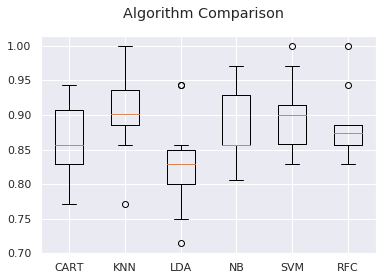

In [23]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(model_results)
ax.set_xticklabels(model_names)
plt.show()

**As you can observe, KNN Model gives us the highest accuracy of 91.11%**

**KNN Model Predictions & Metrics****

In [24]:
#Instantiating KNN Model
knc = KNeighborsClassifier(n_neighbors=3, metric='minkowski')


In [25]:
#Training the KNN Model
knc.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [26]:
#Making a prediction
y_pred = knc.predict(X_test)

# -- Calculating Metrics 
print("Trained Model Accuracy Score - KNN Model: ",'{:.2%}'.format(accuracy_score(y_test,y_pred)) )

Trained Model Accuracy Score - KNN Model:  87.18%


**Making Prediction on Unseen Data**

In [27]:
unseen_df.head(10)

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,Not Purchased
1,1,35,20000,Not Purchased
2,0,26,43000,Not Purchased
3,0,27,57000,Not Purchased
4,1,19,76000,Not Purchased
5,1,27,58000,Not Purchased
6,0,27,84000,Not Purchased
7,0,32,150000,Purchased
8,1,25,33000,Not Purchased
9,0,35,65000,Not Purchased


In [28]:
#Making prediction on unseen data
unseenData_pred = knc.predict(unseen_df.iloc[:,0:3])

#Appending the prediction to the unseen dataset
unseen_df['Pred_Purchased'] = unseenData_pred

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [29]:
unseen_df.head(10)

,Gender,Age,EstimatedSalary,Purchased,Pred_Purchased
0,1,19,19000,Not Purchased,Purchased
1,1,35,20000,Not Purchased,Purchased
2,0,26,43000,Not Purchased,Purchased
3,0,27,57000,Not Purchased,Purchased
4,1,19,76000,Not Purchased,Purchased
5,1,27,58000,Not Purchased,Purchased
6,0,27,84000,Not Purchased,Purchased
7,0,32,150000,Purchased,Purchased
8,1,25,33000,Not Purchased,Purchased
9,0,35,65000,Not Purchased,Purchased


In [30]:
# -- Calculating Metrics 
print("Trained KNN Model Accuracy Score on unseen data: ",'{:.2%}'.format(accuracy_score(unseen_df['Purchased'],unseenData_pred)) )

Trained KNN Model Accuracy Score on unseen data:  10.00%


I believe that the low accuracy on the unseen data is due to the fact that the model has been trained on less number of data records i.e. around 360. 